In [1]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
PV = "age"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metrics = [
    (f"test/lungOpacity_{groups[0]}_fpr@0.95", f"test/lungOpacity_{groups[1]}_fpr@0.95", "fpr@0.95tpr"),
    (f"test/lungOpacity_{groups[0]}_tpr@0.05", f"test/lungOpacity_{groups[1]}_tpr@0.05", "tpr@0.05fpr"),
    (f"test/lungOpacity_{groups[0]}_anomaly_score", f"test/lungOpacity_{groups[1]}_anomaly_score", "anomaly score"),
    (f"test/lungOpacity_{groups[0]}_AUROC", f"test/lungOpacity_{groups[1]}_AUROC", "AUROC"),
    (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC", "subgroupAUROC"),
    (f"test/lungOpacity_{groups[0]}_AP", f"test/lungOpacity_{groups[1]}_AP", "AP")
]
metrics_unwrapped = [item for sublist in [m[0:2] for m in metrics] for item in sublist]

In [3]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [4]:
df = load_csvs_into_df('./')
df = df[['seed','effective_dataset_size',*metrics_unwrapped,'protected_attr_percent']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','effective_dataset_size'])
df.head()

,seed,protected_attr_percent,effective_dataset_size,variable,value
0,1,0.5,0.005,test/lungOpacity_old_fpr@0.95,0.98
1,2,0.5,0.100,test/lungOpacity_old_fpr@0.95,0.90
2,1,0.5,0.100,test/lungOpacity_old_fpr@0.95,0.90
3,3,0.5,0.100,test/lungOpacity_old_fpr@0.95,0.86
4,1,0.5,0.008,test/lungOpacity_old_fpr@0.95,0.98


In [5]:
# load effective_dataset_size 1 from other experiment
df_1 = load_csvs_into_df('../2023-10-07 21:31:36-FAE-rsna-age-bs512-DP-FINAL')
df_1 = df_1[['seed',*metrics_unwrapped,'protected_attr_percent']]
df_1['effective_dataset_size'] = 1
df_1 = pd.melt(df_1, id_vars=['seed','protected_attr_percent','effective_dataset_size'])
df_1 = df_1[df_1.protected_attr_percent.isin(df.protected_attr_percent.unique())]
df_1.head()

,seed,protected_attr_percent,effective_dataset_size,variable,value
9,2,0.5,1,test/lungOpacity_old_fpr@0.95,0.88
10,1,0.5,1,test/lungOpacity_old_fpr@0.95,0.88
11,3,0.5,1,test/lungOpacity_old_fpr@0.95,0.70
24,2,0.5,1,test/lungOpacity_young_fpr@0.95,0.84
25,1,0.5,1,test/lungOpacity_young_fpr@0.95,0.86


In [6]:
df = pd.concat([df,df_1])
df = df.sort_values(by=['protected_attr_percent','effective_dataset_size',"variable"], ascending=False)

In [7]:
sizes = df.effective_dataset_size.unique()
sizes

array([1.   , 0.7  , 0.4  , 0.1  , 0.01 , 0.008, 0.005, 0.001])

In [8]:
def generate_plot(sub, metric):
    #sub.variable = sub.variable.str.replace(metric[1],groups[1])
    #sub.variable = sub.variable.str.replace(metric[0],groups[0])
    sub_sizes = sub.effective_dataset_size.unique()
    sub = sub.sort_values(by=['variable'], ascending=False)
    plt.figure(figsize=(10,5))
    g = sns.barplot(data=sub, x="effective_dataset_size", y="value", hue="variable")
    custom_colors = ["#5975A4"]*(len(sub_sizes)-1) + ["#79a0e0"] + ["#CC8963"]*(len(sub_sizes)-1) + ["#e1a07a"]
    for i, bar in enumerate(g.patches):
        bar.set_color(custom_colors[i])
    plt.title(f'fraction of "old" subgroup in training data: {0.5*100:.0f}%')
    plt.xlabel('effective_dataset_size')
    plt.ylabel(metric[2])
    plt.legend(loc="lower right")
    plt.show()

The 'most fair' dataset-size is at index 1 with size 0.7


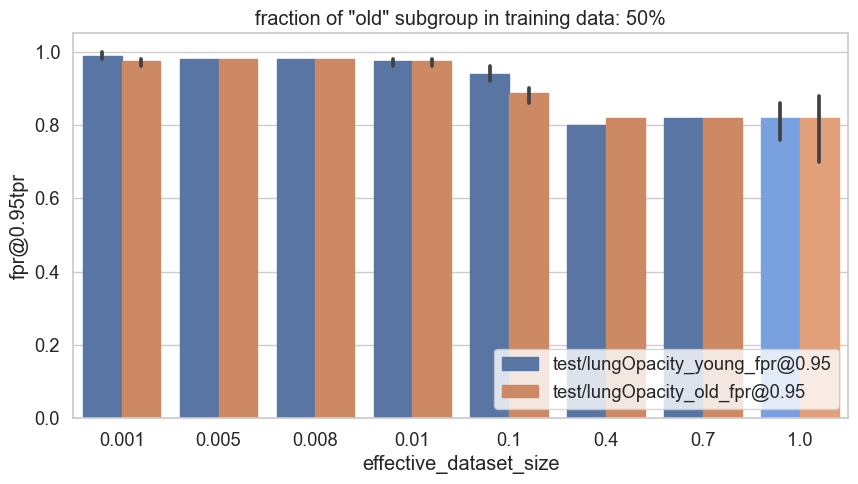

The 'most fair' dataset-size is at index 5 with size 0.008


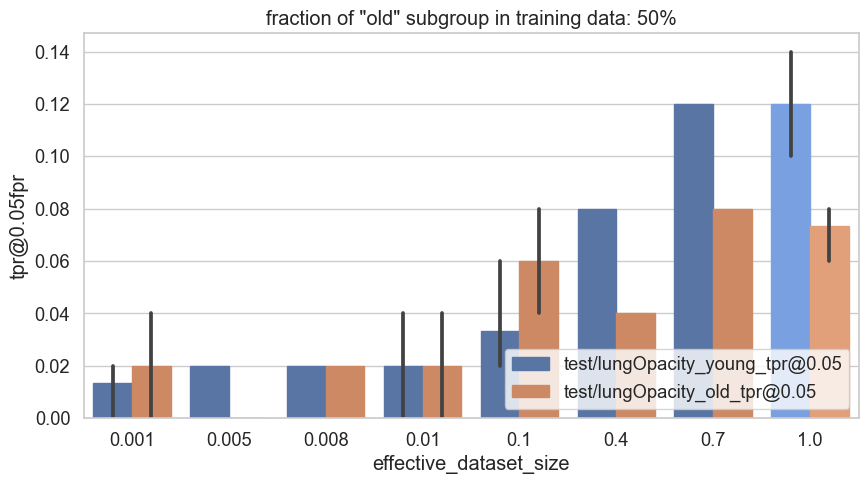

The 'most fair' dataset-size is at index 5 with size 0.008


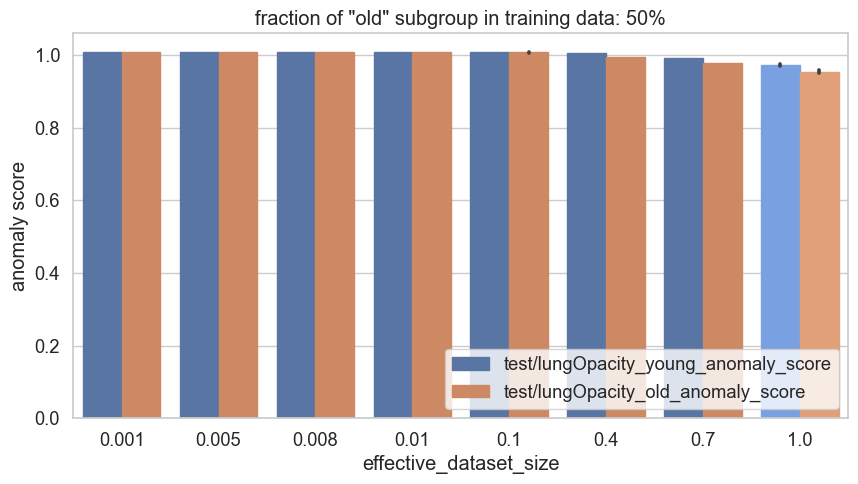

The 'most fair' dataset-size is at index 6 with size 0.005


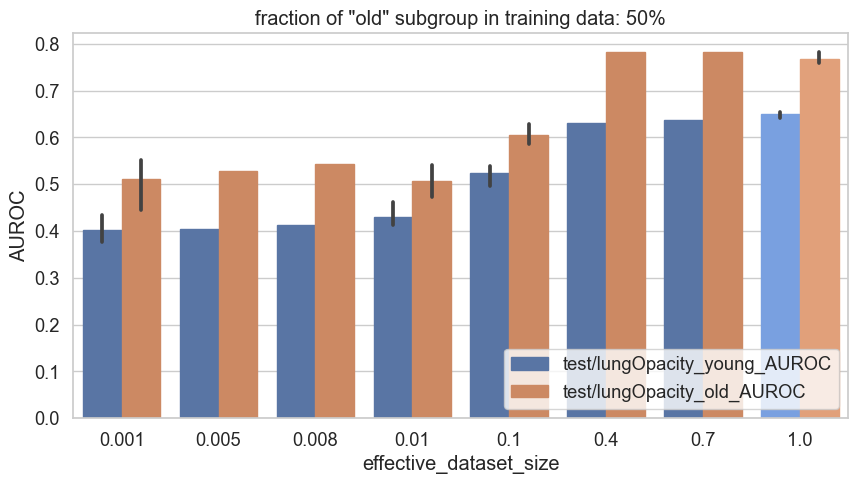

The 'most fair' dataset-size is at index 6 with size 0.005


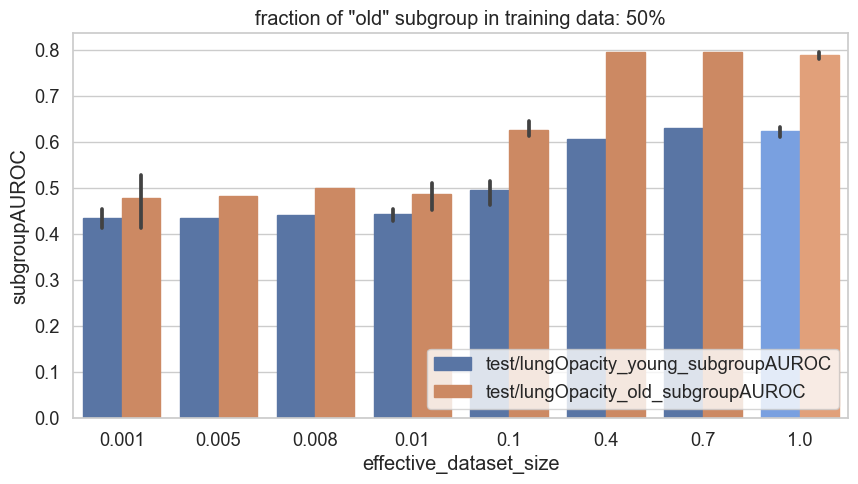

The 'most fair' dataset-size is at index 5 with size 0.008


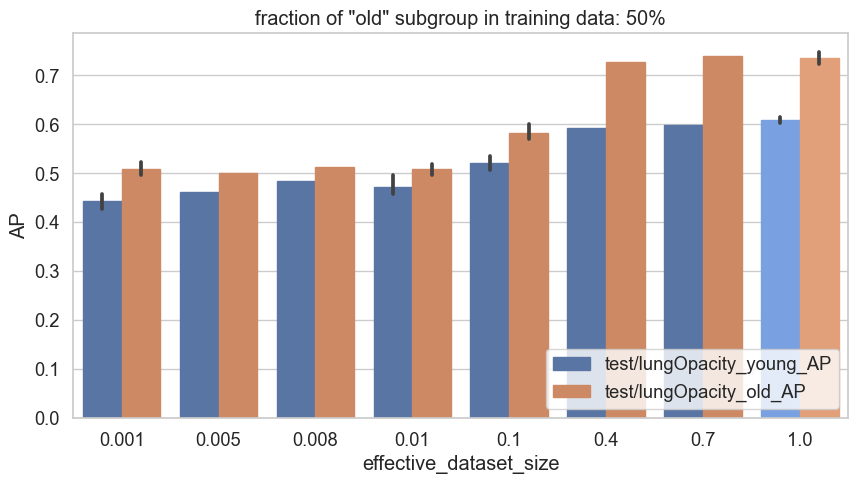

In [9]:
for metric in metrics:
    min_dist = np.inf
    best_dss = None
    best_dss_max = None
    best_dss_min = None
    sub = df.loc[df['variable'].isin(metric[0:2])]
    for idx, w in enumerate(sizes):
        sub_w = sub[sub.effective_dataset_size==w]
        dist = sub_w.value.max() - sub_w.value.min()
        if dist < min_dist:
            min_dist = dist
            best_dss = idx
            best_dss_max = sub_w.value.max()
            best_dss_min = sub_w.value.min()
    print("The 'most fair' dataset-size is at index", best_dss, "with size", sizes[best_dss])
    # sort sub by variable
    sub = sub.sort_values(by=['variable'], ascending=True)
    generate_plot(sub, metric)